In [1]:
!pip install -qq diffusers==0.31


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), Posix

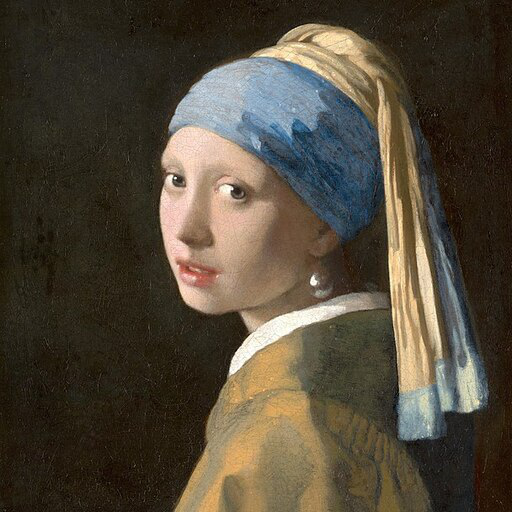

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

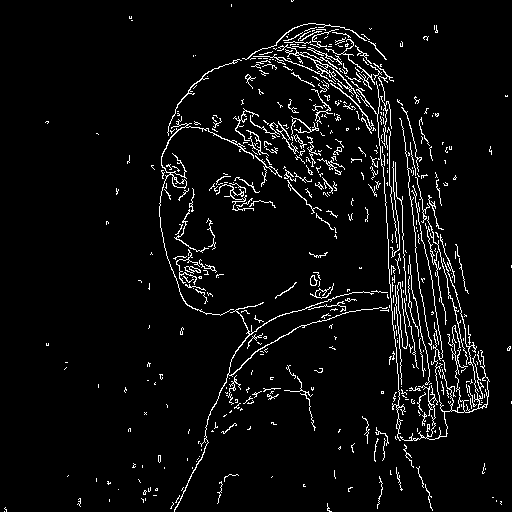

In [3]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [4]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

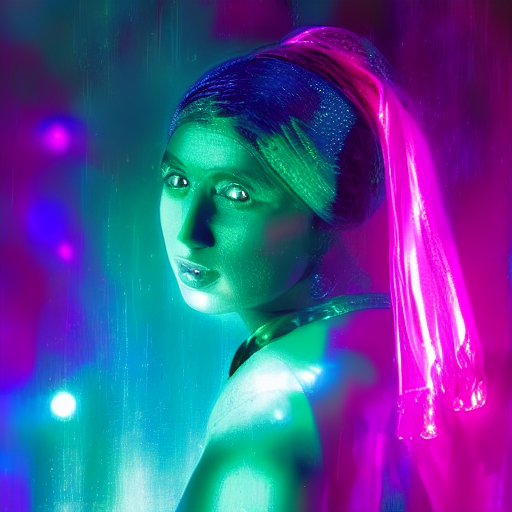

In [5]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

  0%|          | 0/25 [00:00<?, ?it/s]

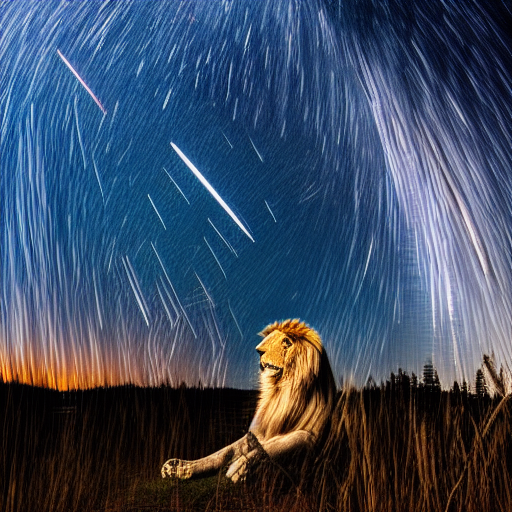

In [6]:
# 이미지를 생성합니다.
new_canny_image = canny_pipe(
    prompt="a majestic lion sitting on a rock under a starry night sky", # 새로운 프롬프트
    num_inference_steps=25, # 추론 스텝 수 변경
    generator=generator,
    image=canny_image,
    guidance_scale=8.0, # Guidance scale 값 조절
    negative_prompt="cartoon, unrealistic, simple" # Negative prompt 추가
).images[0]

# 생성된 이미지를 저장합니다.
new_canny_image.save("/aiffel/aiffel/new_canny_image_simple.png")

# 생성된 이미지를 출력합니다.
new_canny_image

In [7]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

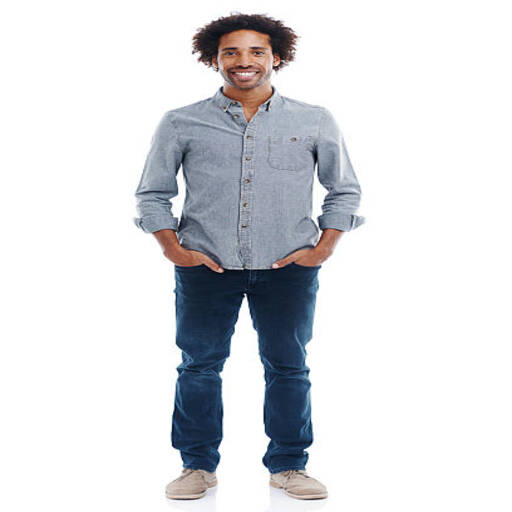

In [8]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


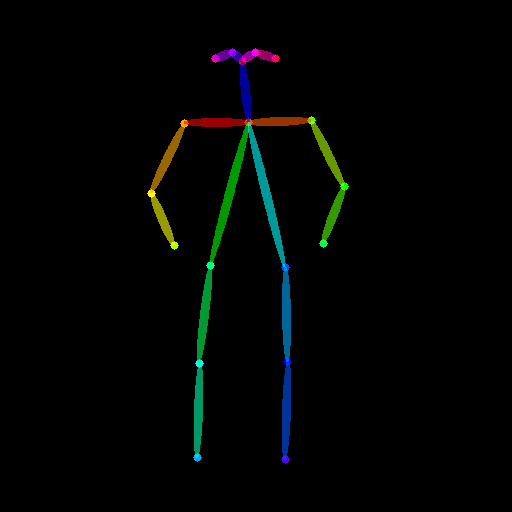

In [9]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [10]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

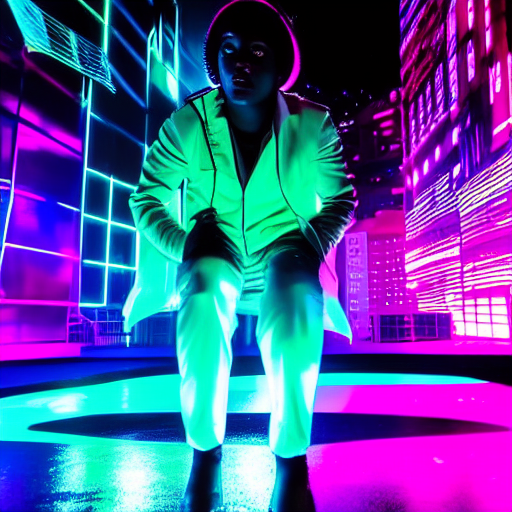

In [11]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)

#프롬프트를 작성합니다.
prompt = "a person dancing in a futuristic city at night with neon lights"
negative_prompt = "blurry, low quality, unrealistic, deformed"

images = openpose_image

# 이미지를 생성합니다.
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=images,
    num_inference_steps=30,
    generator=generator
).images[0]

# 생성된 이미지를 출력합니다.
openpose_image1

  0%|          | 0/40 [00:00<?, ?it/s]

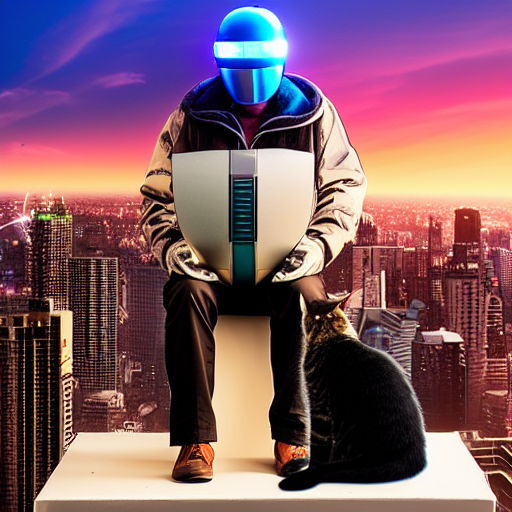

In [12]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 
new_prompt = "a cat wearing a cyberpunk helmet, sitting on a rooftop overlooking a rainy cityscape at sunset"
new_negative_prompt = "deformed, blurry, low quality, multiple limbs, extra fingers"

# 하이퍼파라미터 조절
num_inference_steps = 40  # 추론 스텝 수를 늘려 이미지 품질 향상 시도
guidance_scale = 7.5       # Guidance scale을 조절하여 프롬프트의 영향력 조절 (기본값은 7.5)
generator = torch.manual_seed(42) # 다른 시드를 사용하여 다른 결과 얻기

# 이미지를 생성합니다.
openpose_image2 = openpose_pipe(
    prompt=new_prompt,
    negative_prompt=new_negative_prompt,
    image=images,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=generator
).images[0]

# 생성된 이미지를 출력하거나 저장할 수 있습니다.
# 예시: 생성된 이미지를 화면에 표시
openpose_image2.show()

# 예시: 생성된 이미지를 파일로 저장
openpose_image2.save("generated_image_2.png")

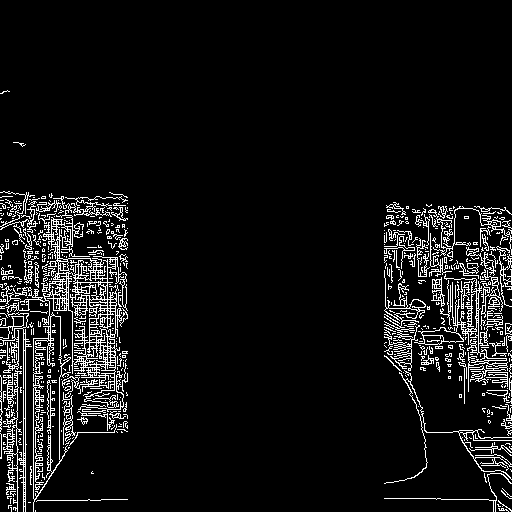

In [1]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요.
image_path = "generated_image_2.png"  # 여기에 이미지 파일 경로를 넣어주세요.
canny_image = load_image(image_path)
canny_image = np.array(canny_image)

#threshhold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다.
canny_image = cv2.cvtColor(canny_image, cv2.COLOR_RGB2BGR)
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다.
canny_image = Image.fromarray(canny_image)
canny_image = canny_image.convert("RGB")
canny_image = canny_image

# 생성된 이미지를 표시합니다.
canny_image.show()

cuda


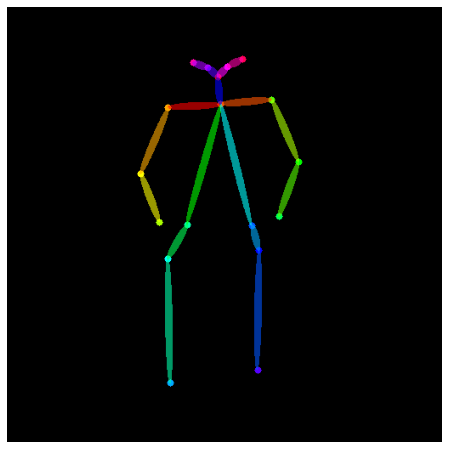

In [2]:
import matplotlib.pyplot as plt
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# 이미지를 불러옵니다.
image_path = "generated_image_2.png"  # 여기에 이미지 경로를 입력하세요.
openpose_image = load_image(image_path)

# OpenposeDetector를 사용하여 인체 자세를 검출합니다.
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
pose_detected_image = openpose(openpose_image)

# 이미지를 출력합니다.
plt.figure(figsize=(8, 8))
plt.imshow(pose_detected_image)
plt.axis("off")  # 축 숨기기
plt.show()



In [3]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  
import torch

# Q. 코드를 작성해 보세요.

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)

# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnets = [canny_controlnet, openpose_controlnet]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")


# 프롬프트를 작성합니다. 
prompt =  ["a futuristic samurai in a battle stance, neon lights, cyberpunk city", " soccer player kicking a ball, cinematic lighting, ultra-realistic"]
negative_prompt = ["blurry"] * 2

# seed를 지정합니다. 
generator = torch.manual_seed(2)

# ✅ ControlNet에 전달할 입력 이미지 (512x512로 크기 조정)
image_size = (512, 512)  # ✅ Stable Diffusion 모델이 기대하는 크기
openpose_image = openpose_image.resize(image_size, Image.LANCZOS)  # 이미지 리사이징
canny_image = canny_image.resize(image_size, Image.LANCZOS)  # 이미지 리사이징

images = [canny_image, openpose_image]







===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), Posix

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/10 [00:00<?, ?it/s]

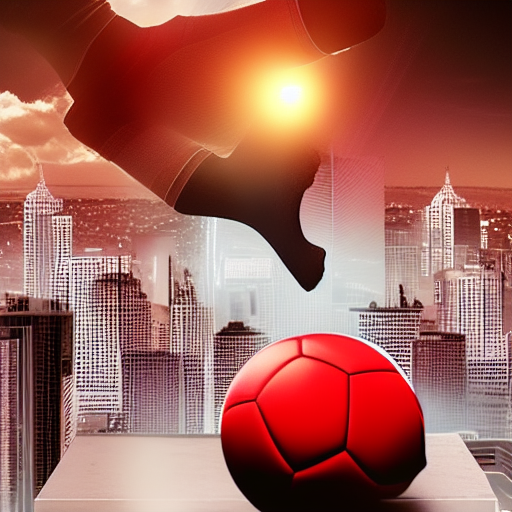

In [4]:
# 이미지를 생성합니다. 
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=10, 
    generator=generator, 
    image=images
).images

# 생성된 이미지를 저장합니다.
image[0].save("aiffel/multi_controlnet_output_3.png")
image[1].save("aiffel/multi_controlnet_output_4.png")


# 생성된 이미지를 출력합니다.  
image[0]
image[1]